# Drive'dan veri setini yükleme

In [ ]:
#  Google Drive'ı Bağla
from google.colab import drive
drive.mount('/content/drive')

import os


zip_yolu = "/content/drive/MyDrive/Derin_Ogrenme/chess_data.rar"

if not os.path.exists("/content/chess_data"):
  os.makedirs("/content/chess_data", exist_ok=True)

rar_yolu = "/content/drive/MyDrive/Derin_Ogrenme/chess_data.rar"
hedef_klasor = "/content/chess_data"

!unrar x "$rar_yolu" "$hedef_klasor"

Mounted at /content/drive

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/Derin_Ogrenme/chess_data.rar

Creating    /content/chess_data/chess_data                            OK
Creating    /content/chess_data/chess_data/beyaz_at                   OK
Extracting  /content/chess_data/chess_data/beyaz_at/10.png                 0%  OK 
Extracting  /content/chess_data/chess_data/beyaz_at/14.png                 0%  OK 
Extracting  /content/chess_data/chess_data/beyaz_at/15.png                 0%  OK 
Extracting  /content/chess_data/chess_data/beyaz_at/16.png                 0%  OK 
Extracting  /content/chess_data/chess_data/beyaz_at/19.png                 0%  OK 
Extracting  /content/chess_data/chess_data/beyaz_at/20.png                 1%  OK 
Extracting  /content/chess_data/chess_data/beyaz_at/24.png                 1%  OK 
Extracting  /content/chess_data/chess_d

# Model Eğitimi

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
import os
import json

In [ ]:
# --- 1. AYARLAR VE YOL KONTROLÜ ---
# Sizin belirttiğiniz yeni yol:
VERI_YOLU = "/content/chess_data/chess_data"

IMG_BOYUT = (85, 85)
BATCH_SIZE = 16  # Veri az olduğu için küçük tutuyoruz, model daha sık güncellenir
EPOCHS = 35      # 30-40 arası idealdir, sonuçlara göre artırılabilir

In [ ]:
# Az sayıdaki Şah, Vezir gibi taşları çoğaltmak için ayarlar
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Pikselleri 0-1 arasına çek
    rotation_range=5,           # Hafif döndürme (-5 ile +5 derece)
    width_shift_range=0.05,     # Çok hafif sağa sola kaydırma
    height_shift_range=0.05,    # Çok hafif yukarı aşağı kaydırma
    zoom_range=0.1,             # Hafif yakınlaştırma
    brightness_range=[0.8, 1.2],# Işık değişimi
    validation_split=0.2        # %20'sini test (doğrulama) için ayır
)

In [ ]:
# Eğitim Seti (Train)
train_generator = train_datagen.flow_from_directory(
    VERI_YOLU,
    target_size=IMG_BOYUT,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Doğrulama Seti (Validation)
validation_generator = train_datagen.flow_from_directory(
    VERI_YOLU,
    target_size=IMG_BOYUT,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 651 images belonging to 13 classes.
Found 156 images belonging to 13 classes.


# SINIF AĞIRLIKLARINI HESAPLAMA

In [ ]:
unique_classes = np.unique(train_generator.classes)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

print("Model, az bulunan sınıflara şu kadar kat daha fazla önem verecek:")
for class_id, weight in class_weights_dict.items():
    class_name = list(train_generator.class_indices.keys())[class_id]
    print(f"  - {class_name}: {weight:.2f}x")

Model, az bulunan sınıflara şu kadar kat daha fazla önem verecek:
  - beyaz_at: 1.09x
  - beyaz_fil: 1.11x
  - beyaz_kale: 1.11x
  - beyaz_piyon: 0.63x
  - beyaz_sah: 1.62x
  - beyaz_vezir: 1.62x
  - empty: 0.40x
  - siyah_at: 1.19x
  - siyah_fil: 1.25x
  - siyah_kale: 1.25x
  - siyah_piyon: 0.71x
  - siyah_sah: 1.79x
  - siyah_vezir: 1.79x


#Model Mimarisi (CNN)

In [ ]:
model = Sequential([
    # Giriş Katmanı
    Input(shape=(85, 85, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Sınıflandırma Katmanı
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(13, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# --- CALLBACK TANIMLARI ---

#  EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,                 # 5 epoch boyunca iyileşme yoksa durdur
    restore_best_weights=True,  # En iyi epoch ağırlıklarını geri yükle
    verbose=1
)

#  ModelCheckpoint (GÜNCEL KERAS FORMATI)
checkpoint = ModelCheckpoint(
    "satranc_modeli_en_iyi.keras",  #  .h5 yerine .keras
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# --- EĞİTİM ---
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1002 - loss: 2.5110
Epoch 1: val_accuracy improved from -inf to 0.17949, saving model to satranc_modeli_en_iyi.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.1004 - loss: 2.5122 - val_accuracy: 0.1795 - val_loss: 2.4022
Epoch 2/40
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2535 - loss: 2.0578
Epoch 2: val_accuracy improved from 0.17949 to 0.69872, saving model to satranc_modeli_en_iyi.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.2587 - loss: 2.0520 - val_accuracy: 0.6987 - val_loss: 1.1530
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6626 - loss: 1.2276
Epoch 3: val_accuracy improved from 0.69872 to 0.81410, saving model to satranc_modeli_en_iyi.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.6633 - loss: 1.2244 - val_accuracy: 0.8141 - val_loss: 0.7701
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7673 - loss: 0.8184
Epoch 4: val_accuracy i

In [ ]:
# --- KAYDETME ---
model.save("satranc_modelim.keras")

# Sınıf isimlerini kaydet
with open('sinif_isimleri.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

# Karışıklık Matrisi

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

print("Doğrulama verileri analiz için yükleniyor...")
validation_generator_cm = val_datagen.flow_from_directory(
    VERI_YOLU,
    target_size=IMG_BOYUT,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # <-- KRİTİK NOKTA: Sıralı gelmeli!
)

Doğrulama verileri analiz için yükleniyor...
Found 156 images belonging to 13 classes.


In [ ]:
# --- TAHMİN İşlemi ---
predictions = model.predict(validation_generator_cm, verbose=1)
predicted_classes = np.argmax(predictions, axis=1) # En yüksek olasılıklı sınıfı seç
true_classes = validation_generator_cm.classes     # Gerçek sınıflar
class_labels = list(validation_generator_cm.class_indices.keys()) # Sınıf isimleri

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


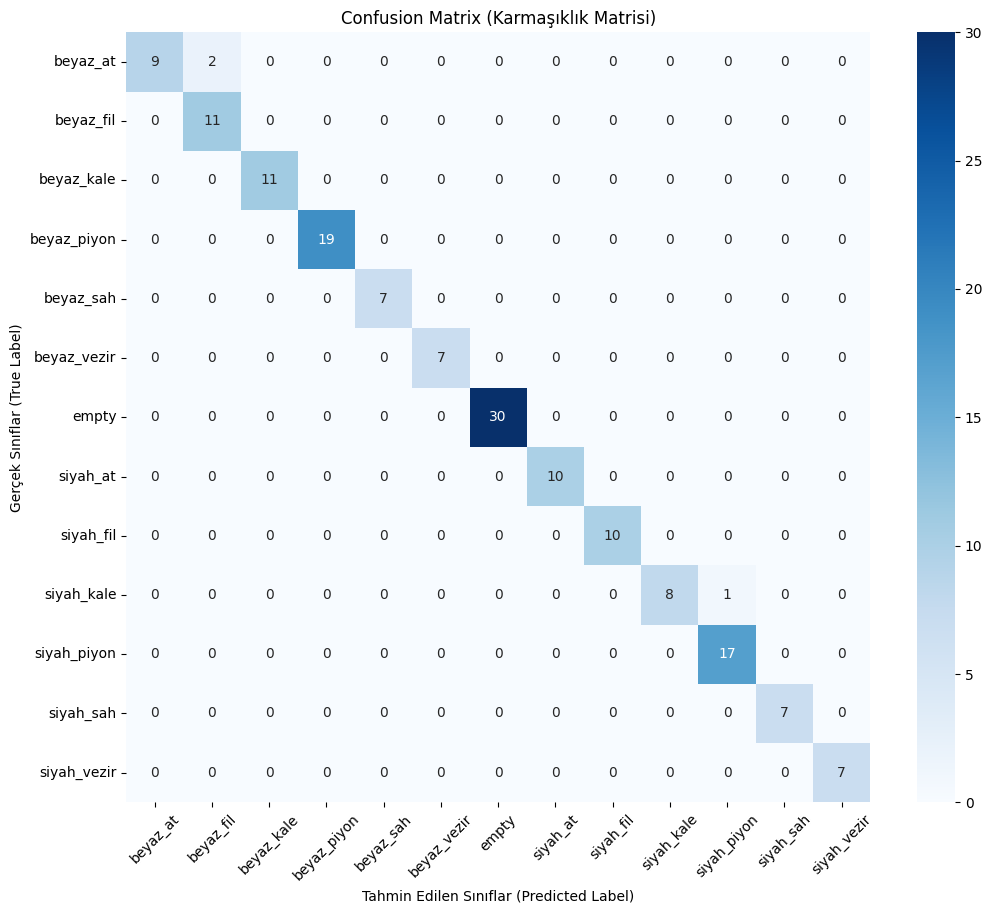

In [ ]:
# --- 4. MATRİSİ HESAPLA VE ÇİZ ---
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.title('Confusion Matrix (Karmaşıklık Matrisi)')
plt.ylabel('Gerçek Sınıflar (True Label)')
plt.xlabel('Tahmin Edilen Sınıflar (Predicted Label)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# --- 5. DETAYLI RAPOR ---
print("\n--- Sınıflandırma Raporu ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

    beyaz_at       1.00      0.82      0.90        11
   beyaz_fil       0.85      1.00      0.92        11
  beyaz_kale       1.00      1.00      1.00        11
 beyaz_piyon       1.00      1.00      1.00        19
   beyaz_sah       1.00      1.00      1.00         7
 beyaz_vezir       1.00      1.00      1.00         7
       empty       1.00      1.00      1.00        30
    siyah_at       1.00      1.00      1.00        10
   siyah_fil       1.00      1.00      1.00        10
  siyah_kale       1.00      0.89      0.94         9
 siyah_piyon       0.94      1.00      0.97        17
   siyah_sah       1.00      1.00      1.00         7
 siyah_vezir       1.00      1.00      1.00         7

    accuracy                           0.98       156
   macro avg       0.98      0.98      0.98       156
weighted avg       0.98      0.98      0.98       156



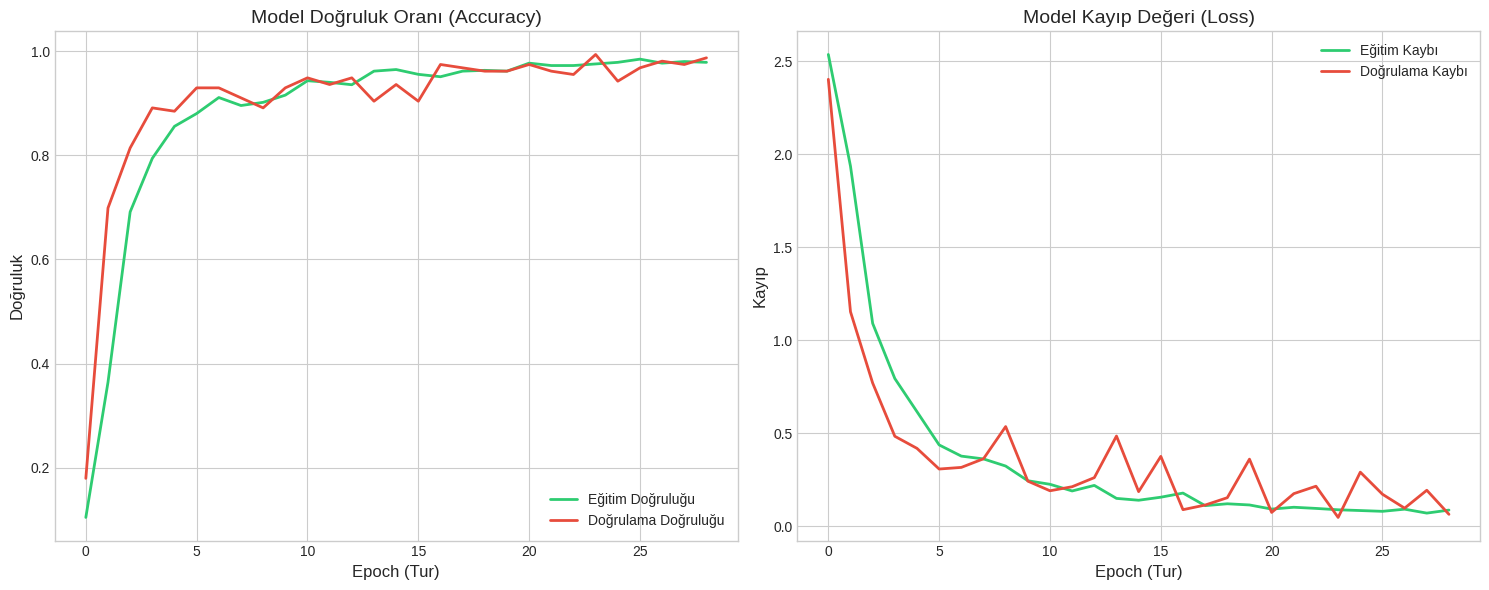

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Grafiklerin boyutunu ve stilini ayarla
plt.figure(figsize=(15, 6))
plt.style.use('seaborn-v0_8-whitegrid') # Daha profesyonel bir görünüm için

# 1. GRAFİK: DOĞRULUK (ACCURACY)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='#2ecc71', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='#e74c3c', linewidth=2)
plt.title('Model Doğruluk Oranı (Accuracy)', fontsize=14)
plt.xlabel('Epoch (Tur)', fontsize=12)
plt.ylabel('Doğruluk', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)

# 2. GRAFİK: KAYIP (LOSS)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='#2ecc71', linewidth=2)
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='#e74c3c', linewidth=2)
plt.title('Model Kayıp Değeri (Loss)', fontsize=14)
plt.xlabel('Epoch (Tur)', fontsize=12)
plt.ylabel('Kayıp', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)

# Grafiklerin birbirine girmemesi için
plt.tight_layout()
plt.show()

# İstersen sunumuna eklemek için görseli kaydet
plt.savefig('egitim_performans_grafikleri.png', dpi=300)

# Test İşlemi

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import os


In [ ]:

import cv2
# --- 1. AYARLAR ---
MODEL_YOLU = "/content/satranc_modeli_en_iyi.keras"  # Model dosyanızın adı
ETIKET_YOLU = "/content/sinif_isimleri.json"       # Etiket dosyanız
TEST_RESMI_YOLU = "/content/test1.jpg" # Test edilecek resmin yolu

def satranc_tespit_uygulamasi(resim_yolu):
    # Dosya kontrolü
    if not os.path.exists(resim_yolu):
        print(f"HATA: '{resim_yolu}' bulunamadı.")
        return

    # 1. Modeli Yükle
    print("Model yükleniyor...")
    try:
        model = tf.keras.models.load_model(MODEL_YOLU)
    except:
        model = tf.keras.models.load_model("satranc_modelim.keras") # Yedek

    # 2. Etiketleri Yükle
    with open(ETIKET_YOLU, 'r') as f:
        class_indices = json.load(f)
    labels = {v: k for k, v in class_indices.items()}

    # 3. Resmi Oku ve 680x680 Yap
    img_bgr = cv2.imread(resim_yolu)

    # --- KRİTİK DÜZELTME: GÖRÜNTÜYÜ 680x680 OLARAK YENİDEN BOYUTLANDIR ---
    # Böylece her kare tam olarak 85x85 piksel olacak.
    img_bgr = cv2.resize(img_bgr, (680, 680))

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # Gösterim için
    cizim_img = img_rgb.copy() # Üzerine çizim yapılacak kopya

    # Artık adım boyutu sabit 85 pikseldir
    step = 85

    print("Analiz Başlıyor... (Görüntü 680x680 px olarak ayarlandı)")

    # --- 4. TARAMA DÖNGÜSÜ ---
    for row in range(8):
        for col in range(8):
            # Koordinatları belirle (Sabit 85'er artacak)
            y1 = row * step
            y2 = (row + 1) * step
            x1 = col * step
            x2 = (col + 1) * step

            # Kareyi kes (Şu an tam olarak 85x85 kesiyoruz)
            kare = img_bgr[y1:y2, x1:x2]

            # Modele hazırla
            # (Zaten 85x85 olduğu için tekrar resize yapmaya gerek yok ama garanti olsun)
            # Normalizasyon (0-1 arası)
            kare_input = kare.astype('float32') / 255.0
            kare_input = np.expand_dims(kare_input, axis=0) # (1, 85, 85, 3)

            # TAHMİN ET
            tahminler = model.predict(kare_input, verbose=0)
            kazanan_index = np.argmax(tahminler)
            kazanan_isim = labels[kazanan_index]
            guven_orani = np.max(tahminler)

            # --- 5. ÇİZİM VE FİLTRELEME ---
            # Sadece "Empty" (Boş) OLMAYANLARI çiz
            if 'empty' not in kazanan_isim.lower() and 'bos' not in kazanan_isim.lower():

                # Konum Yazısı (a8, c3...)
                sutun_harf = chr(ord('a') + col)
                satir_rakam = 8 - row
                konum = f"{sutun_harf}{satir_rakam}"

                print(f"📍 {konum}: {kazanan_isim} (Güven: %{guven_orani*100:.1f})")

                # Kutu Rengi Ayarla
                renk = (0, 255, 0) # Yeşil (Varsayılan)
                if 'siyah' in kazanan_isim.lower() or 'black' in kazanan_isim.lower():
                    renk = (255, 0, 0) # Kırmızı (Siyah Taşlar)

                # Kutu Çiz
                cv2.rectangle(cizim_img, (x1, y1), (x2, y2), renk, 3)

                # Etiket Yaz
                yazi = f"{kazanan_isim} {konum}"
                # Yazının okunması için hafif arka plan efekti (siyah kontur)
                cv2.putText(cizim_img, yazi, (x1, y1 + 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 0), 3) # Kalın siyah
                cv2.putText(cizim_img, yazi, (x1, y1 + 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1) # İnce beyaz

    # --- 6. SONUCU GÖSTER ---
    plt.figure(figsize=(10, 10))
    plt.imshow(cizim_img)
    plt.axis('off')
    plt.title("680x680 Optimize Edilmiş Satranç Analizi")
    plt.show()

    # Kaydet
    cv2.imwrite("sonuc_680x680.jpg", cv2.cvtColor(cizim_img, cv2.COLOR_RGB2BGR))

# ÇALIŞTIR
satranc_tespit_uygulamasi(TEST_RESMI_YOLU)

HATA: '/content/test1.jpg' bulunamadı.


Model yükleniyor...
Analiz Başlıyor... (Görüntü 680x680 px olarak ayarlandı)
📍 f8: beyaz_fil (Güven: %67.8)
📍 g8: siyah_sah (Güven: %46.6)
📍 f7: siyah_piyon (Güven: %96.4)
📍 g7: beyaz_piyon (Güven: %56.2)
📍 h7: siyah_piyon (Güven: %96.2)
📍 a6: beyaz_kale (Güven: %87.9)
📍 g6: siyah_at (Güven: %75.8)
📍 a3: beyaz_piyon (Güven: %99.9)
📍 e3: beyaz_fil (Güven: %99.9)
📍 g3: beyaz_at (Güven: %99.9)
📍 h3: beyaz_piyon (Güven: %100.0)
📍 a2: siyah_vezir (Güven: %76.3)
📍 b2: beyaz_kale (Güven: %89.3)
📍 f2: beyaz_piyon (Güven: %100.0)
📍 g2: beyaz_piyon (Güven: %100.0)
📍 d1: beyaz_kale (Güven: %100.0)
📍 g1: beyaz_sah (Güven: %100.0)


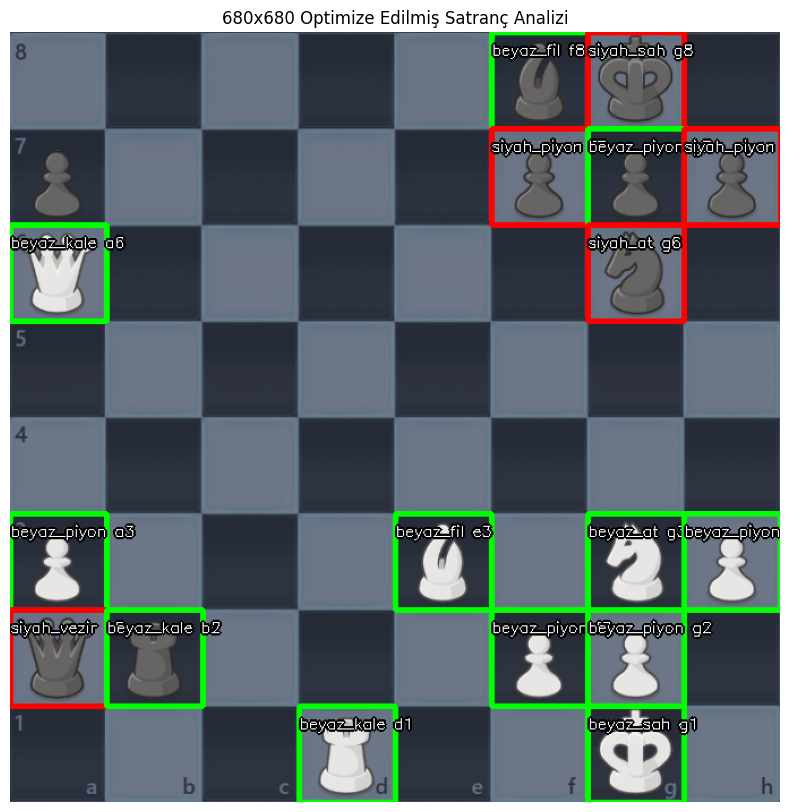

In [ ]:
TEST_RESMI_YOLU = "/content/test2.jpg" # Test edilecek resmin yolu
satranc_tespit_uygulamasi(TEST_RESMI_YOLU)

Model yükleniyor...
Analiz Başlıyor... (Görüntü 680x680 px olarak ayarlandı)
📍 c8: siyah_sah (Güven: %100.0)
📍 h8: siyah_kale (Güven: %100.0)
📍 e7: siyah_piyon (Güven: %99.8)
📍 f7: siyah_piyon (Güven: %100.0)
📍 a6: siyah_at (Güven: %100.0)
📍 d6: beyaz_piyon (Güven: %100.0)
📍 h6: siyah_vezir (Güven: %100.0)
📍 g4: beyaz_fil (Güven: %100.0)
📍 b3: siyah_fil (Güven: %100.0)
📍 c3: beyaz_fil (Güven: %100.0)
📍 f3: beyaz_at (Güven: %100.0)
📍 h3: beyaz_piyon (Güven: %100.0)
📍 e2: beyaz_piyon (Güven: %100.0)
📍 a1: beyaz_kale (Güven: %100.0)
📍 g1: beyaz_sah (Güven: %100.0)


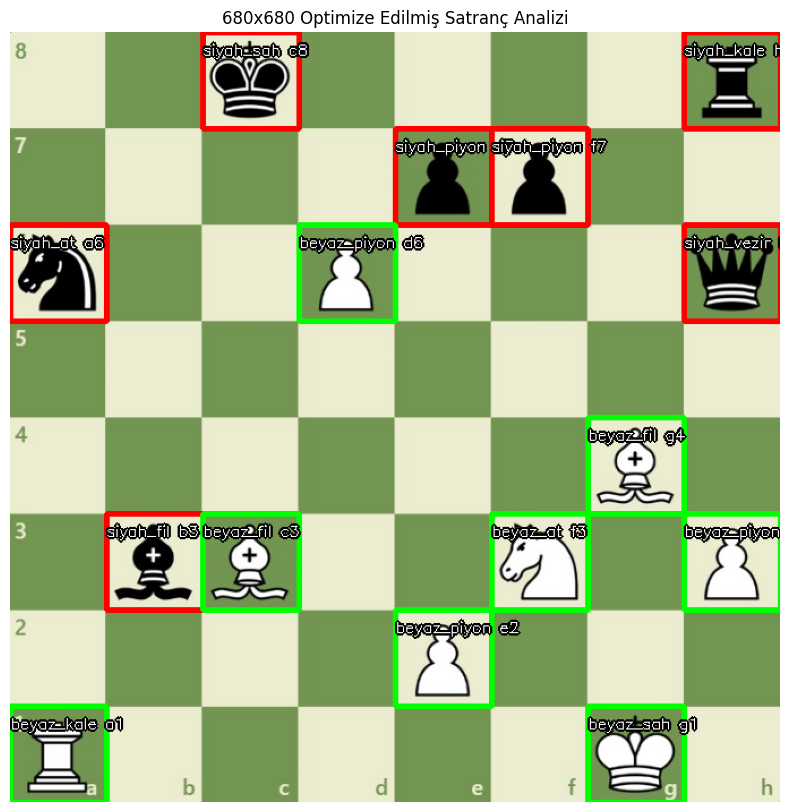

In [ ]:
TEST_RESMI_YOLU = "/content/test3.jpg" # Test edilecek resmin yolu
satranc_tespit_uygulamasi(TEST_RESMI_YOLU)

Model yükleniyor...
Analiz Başlıyor... (Görüntü 680x680 px olarak ayarlandı)
📍 b8: siyah_kale (Güven: %100.0)
📍 d8: siyah_kale (Güven: %100.0)
📍 f7: siyah_sah (Güven: %100.0)
📍 g7: siyah_fil (Güven: %100.0)
📍 a6: siyah_at (Güven: %100.0)
📍 d6: siyah_vezir (Güven: %100.0)
📍 f6: siyah_piyon (Güven: %100.0)
📍 g6: siyah_piyon (Güven: %100.0)
📍 d5: siyah_piyon (Güven: %100.0)
📍 e4: siyah_piyon (Güven: %100.0)
📍 g4: siyah_at (Güven: %52.6)
📍 a3: siyah_piyon (Güven: %100.0)
📍 e3: beyaz_vezir (Güven: %62.7)
📍 g3: siyah_piyon (Güven: %98.7)
📍 e2: siyah_piyon (Güven: %98.3)
📍 f2: siyah_piyon (Güven: %96.3)
📍 g2: siyah_fil (Güven: %98.8)
📍 h2: siyah_piyon (Güven: %98.1)
📍 b1: siyah_kale (Güven: %73.4)
📍 d1: siyah_kale (Güven: %96.9)
📍 g1: beyaz_sah (Güven: %80.1)


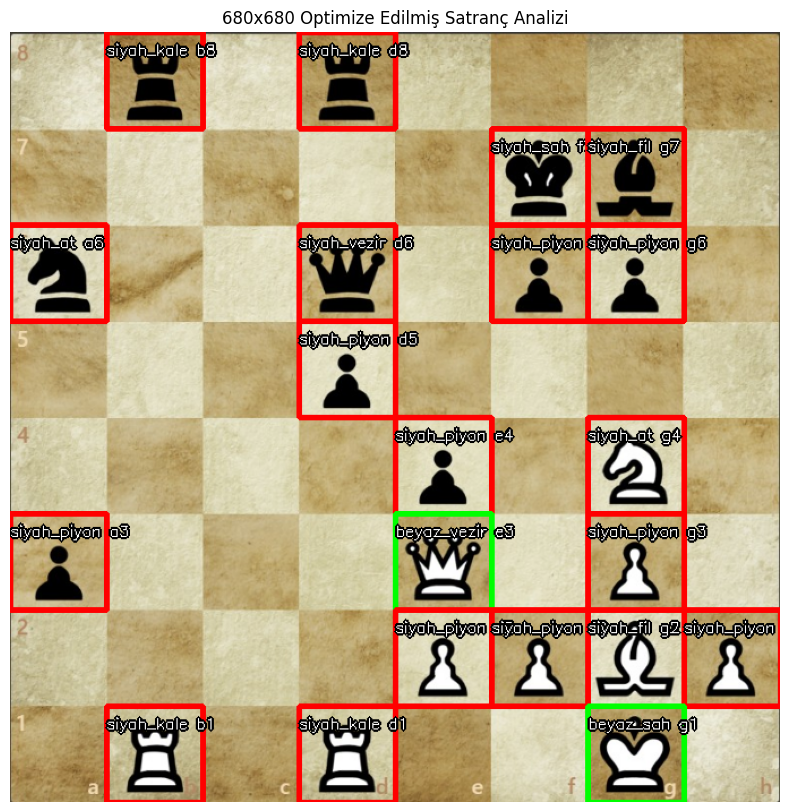

In [ ]:
TEST_RESMI_YOLU = "/content/test4.jpg" # Test edilecek resmin yolu
satranc_tespit_uygulamasi(TEST_RESMI_YOLU)

Model yükleniyor...
Analiz Başlıyor... (Görüntü 680x680 px olarak ayarlandı)
📍 c8: siyah_sah (Güven: %100.0)
📍 b7: siyah_fil (Güven: %100.0)
📍 f7: beyaz_kale (Güven: %92.5)
📍 h7: siyah_piyon (Güven: %52.8)
📍 f6: siyah_piyon (Güven: %63.3)
📍 c5: siyah_at (Güven: %99.9)
📍 d4: beyaz_vezir (Güven: %100.0)
📍 g4: beyaz_at (Güven: %100.0)
📍 b3: siyah_vezir (Güven: %100.0)
📍 e3: beyaz_piyon (Güven: %92.5)
📍 g3: beyaz_fil (Güven: %100.0)
📍 f2: beyaz_sah (Güven: %100.0)
📍 h2: beyaz_piyon (Güven: %93.2)
📍 a1: siyah_kale (Güven: %100.0)
📍 d1: beyaz_kale (Güven: %85.6)


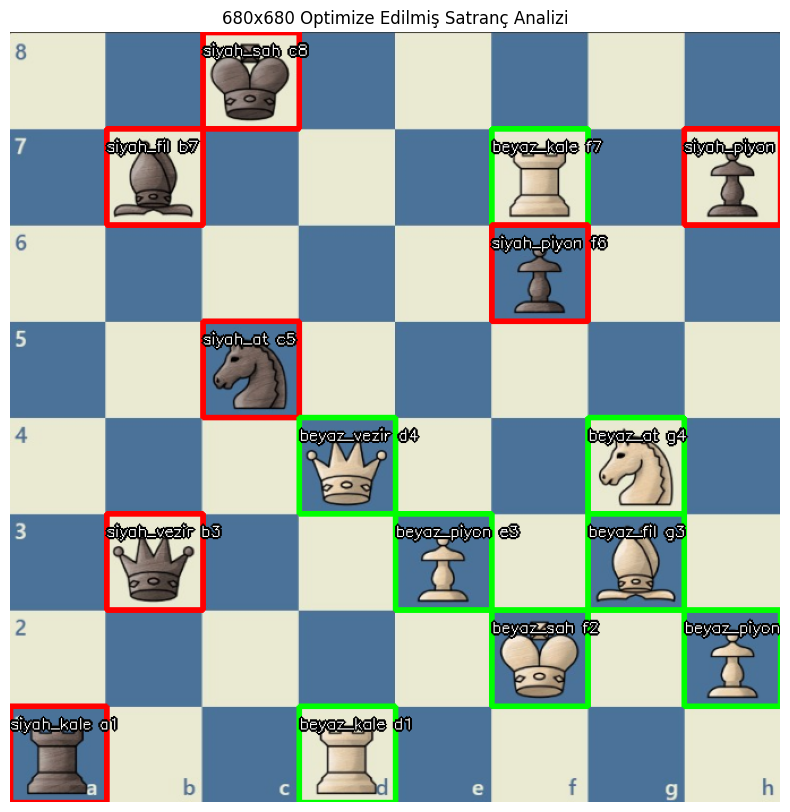

In [ ]:
TEST_RESMI_YOLU = "/content/test5.jpg" # Test edilecek resmin yolu
satranc_tespit_uygulamasi(TEST_RESMI_YOLU)

Model yükleniyor...
Analiz Başlıyor... (Görüntü 680x680 px olarak ayarlandı)
📍 c8: siyah_kale (Güven: %97.1)
📍 g8: siyah_sah (Güven: %100.0)
📍 a7: beyaz_piyon (Güven: %99.7)
📍 b7: siyah_at (Güven: %100.0)
📍 e7: siyah_vezir (Güven: %100.0)
📍 g7: siyah_at (Güven: %100.0)
📍 b3: beyaz_at (Güven: %100.0)
📍 f3: siyah_fil (Güven: %100.0)
📍 g3: beyaz_at (Güven: %100.0)
📍 d2: beyaz_vezir (Güven: %99.6)
📍 g2: siyah_fil (Güven: %100.0)
📍 a1: beyaz_kale (Güven: %100.0)
📍 f1: beyaz_sah (Güven: %98.8)


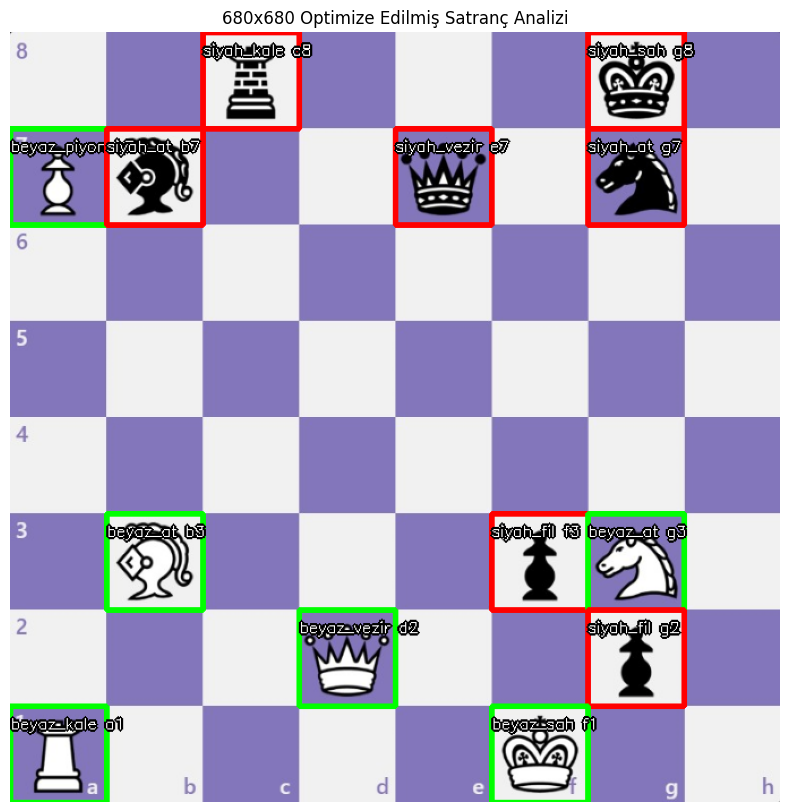

In [ ]:
TEST_RESMI_YOLU = "/content/test6.jpg" # Test edilecek resmin yolu
satranc_tespit_uygulamasi(TEST_RESMI_YOLU)

Model yükleniyor...
Analiz Başlıyor... (Görüntü 680x680 px olarak ayarlandı)
📍 e8: siyah_sah (Güven: %100.0)
📍 b7: siyah_at (Güven: %100.0)
📍 d7: siyah_piyon (Güven: %53.0)
📍 h7: siyah_piyon (Güven: %63.1)
📍 d6: siyah_fil (Güven: %100.0)
📍 f6: siyah_vezir (Güven: %92.9)
📍 a5: siyah_kale (Güven: %100.0)
📍 e4: beyaz_vezir (Güven: %99.8)
📍 b3: beyaz_at (Güven: %100.0)
📍 g3: beyaz_fil (Güven: %100.0)
📍 c2: beyaz_kale (Güven: %100.0)
📍 e2: beyaz_sah (Güven: %100.0)
📍 h2: beyaz_piyon (Güven: %81.7)
📍 h1: beyaz_fil (Güven: %24.0)


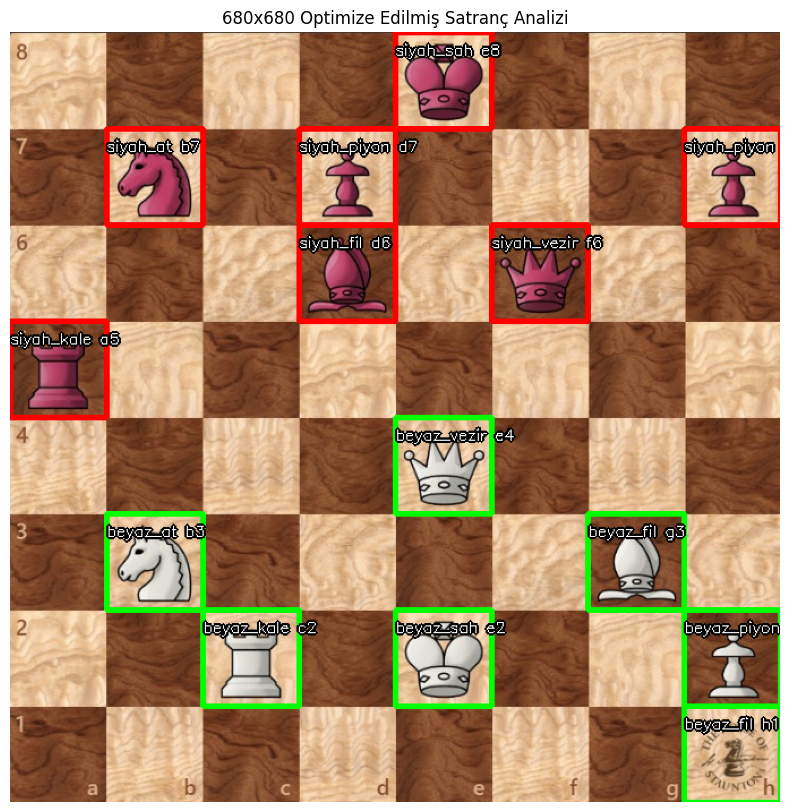

In [ ]:
TEST_RESMI_YOLU = "/content/test7.jpg" # Test edilecek resmin yolu
satranc_tespit_uygulamasi(TEST_RESMI_YOLU)

Model yükleniyor...
Analiz Başlıyor... (Görüntü 680x680 px olarak ayarlandı)
📍 d8: beyaz_kale (Güven: %100.0)
📍 a7: beyaz_piyon (Güven: %100.0)
📍 f7: beyaz_at (Güven: %100.0)
📍 h7: beyaz_piyon (Güven: %100.0)
📍 b6: beyaz_fil (Güven: %100.0)
📍 a5: beyaz_vezir (Güven: %99.8)
📍 d5: beyaz_sah (Güven: %100.0)
📍 f5: siyah_piyon (Güven: %96.3)
📍 a4: siyah_piyon (Güven: %92.4)
📍 e4: siyah_fil (Güven: %80.1)
📍 h4: beyaz_piyon (Güven: %66.7)
📍 b3: siyah_at (Güven: %88.5)
📍 g3: beyaz_kale (Güven: %92.8)
📍 c2: siyah_sah (Güven: %77.2)
📍 e2: siyah_vezir (Güven: %87.7)
📍 a1: beyaz_at (Güven: %94.5)
📍 f1: siyah_kale (Güven: %83.7)


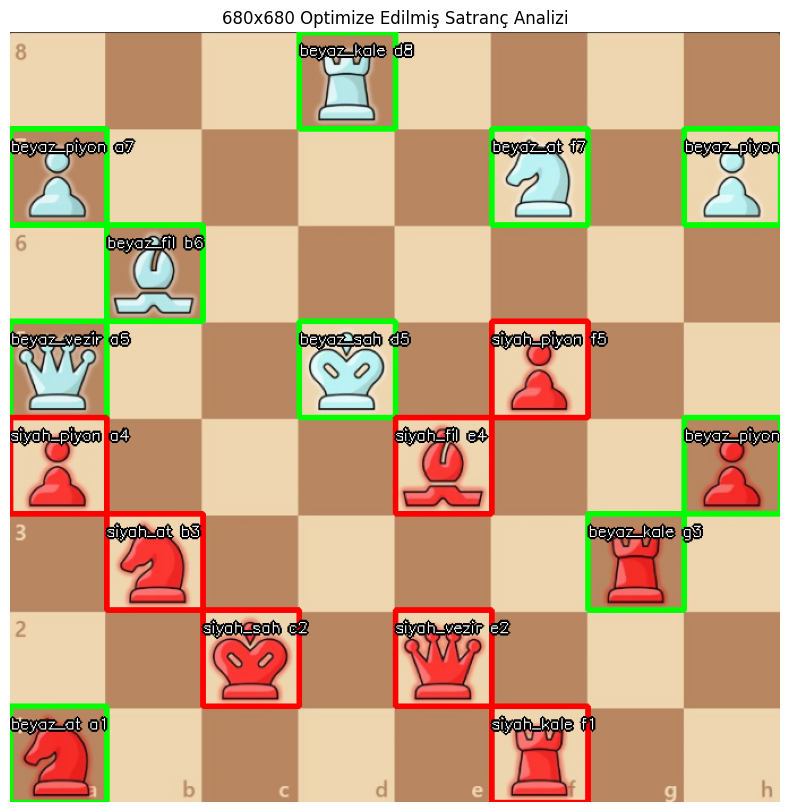

In [ ]:
TEST_RESMI_YOLU = "/content/test8.jpg" # Test edilecek resmin yolu
satranc_tespit_uygulamasi(TEST_RESMI_YOLU)